In [331]:
import time

In [1]:
from scipy.special import digamma
from numpy import log

In [2]:
from random import uniform

import numpy as np
from multivariate_util import *

In [166]:
from matplotlib.animation import FuncAnimation, ArtistAnimation
import matplotlib.pyplot as plt

In [375]:
size = 150

actual_mu01  = [-4, .4]
actual_cov01 = [[.40, 0], [.7, 1.55]]
actual_df01  = 27
x01 = multivariate_t_rvs(m=actual_mu01, S=actual_cov01, df=actual_df01, n=size)

actual_mu02  = [.9, -.5]
actual_cov02 = [[1.5, 0.7], [0, 0.5]]
actual_df02  = 47
x02 = multivariate_t_rvs(m=actual_mu02, S=actual_cov02, df=actual_df02, n=size)

x01 = np.concatenate([x01, x02])

In [376]:
actual_t01 = multivariate_t(actual_mu01, actual_cov01, actual_df01)
actual_t02 = multivariate_t(actual_mu02, actual_cov02, actual_df02)

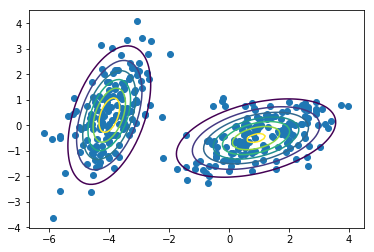

In [377]:
xmin, xmax = min(x01.T[0]), max(x01.T[0])
ymin, ymax = min(x01.T[1]), max(x01.T[1])

x, y = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
xy   = np.column_stack([x.ravel(), y.ravel()])

plt.scatter(x01.T[0], x01.T[1])
plt.contour(x, y, np.reshape(actual_t01.pdf(xy), x.shape))
plt.contour(x, y, np.reshape(actual_t02.pdf(xy), x.shape))

plt.show()

In [5]:
def get_random(X):
    size = len(X)
    idx = np.random.choice(range(size))
    return X[idx]

In [353]:
class MultivariateTMixture:
    """
    Parameters
    ----------
    n_components: number of components
    """
    def __init__(self, n_components):
        self.n_components = n_components
    
    def fit(self, X):
        self.p = X.shape[1]
        xmin = get_random(X)
        xmax = get_random(X)
        xcov = np.cov(X.T.copy())
        self.mixes = [multivariate_t(mu=uniform(xmin, xmax), sigma=xcov, df=4) for _ in range(self.n_components)]
        self.pi    = [1./self.n_components for _ in range(self.n_components)]
    
    def __calc_tau(self, X):
        # E-step: Calculating tau
        self.weights = {}
        for idx in range(self.n_components):
            self.weights[idx] = (self.mixes[idx].pdf(X) * self.pi[idx]).reshape(-1, 1)
        weights_total = sum(self.weights.values())
        self.weights_total = weights_total
        
        for idx, _ in enumerate(self.weights):
            self.weights[idx] /= weights_total
    
    def __calc_u(self, X):
        # E-Step: Calculating u
        self.u = {}
        for idx in range(self.n_components):
            _ = []
            for delta in (X-self.mixes[idx].mu):
                _.append(delta.dot(inv(self.mixes[idx].sigma)).dot(delta))
            _ = np.array(_)
            self.u[idx] = (self.mixes[idx].df + self.p)/(self.mixes[idx].df + _)
            self.u[idx] = self.u[idx].reshape(-1, 1)
    
    def e_step1(self, X):
        self.__calc_tau(X)
        self.__calc_u(X)
    
    def e_step2(self, X):
        self.__calc_u(X)

    def cm_step1(self, X):
        for idx, _ in enumerate(self.mixes):
            # Assigning mu and cov
            self.mixes[idx].mu, self.mixes[idx].sigma = self.__estimate_parameters(X, self.u[idx], self.weights[idx])

    def __estimate_parameters(self, X, u, tau):
        mu_ = (tau * u * X).sum(axis=0) / (tau * u).sum() # Here I could improve somehow...
        
        cov_ = np.array([[0,0], [0,0]], dtype=np.float32)
        for idx, delta in enumerate(X - mu_):
            delta = delta.reshape(-1, 1)
            cov_ += (tau[idx] * u[idx] * delta).dot(delta.T)
        
        cov_ /= tau.sum()
        
        return mu_, cov_

    def __estimate_dof(self, v, u, tau):
        return -digamma(v/2.) + log(v/2.) + (tau * (log(u) - u)).sum()/tau.sum() + 1 + (digamma((v+self.p)/2.)-log((v+self.p)/2.))
    
    def cm_step2(self, X):
        for idx, _ in enumerate(self.mixes):
            arange = np.arange(_.df, _.df+3, .01)
            for df in arange:
                solution = self.__estimate_dof(df, self.u[idx], self.weights[idx])
                if solution < 0+1e-4 and solution > 0-1e-4:
                    # Assigning degrees of freedom
                    _.df = df
                    break

        for idx, pi in enumerate(self.pi):
            self.pi[idx] = sum(self.weights[idx])/len(self.weights[idx])
    
    def pdf(self, X):
        result = []
        for idx, mix in enumerate(self.mixes):
            result.append(mix.pdf(X) * self.pi)

    def log_likelihood(self, X):
        likelihood = 0
        for _ in self.pi:
            likelihood += len(X) * log(_)
        
        for mix in self.mixes:
            likelihood += log(mix.pdf(X)).sum()
        
        return likelihood
    
    def iterate(self, X):
        self.e_step1(x01)
        self.cm_step1(x01)
        self.e_step2(x01)
        self.cm_step2(x01)
    
    def iterate2(self, X):
        start = time.time()
        self.e_step1(x01)
        end   = time.time()
        print '\n\nestep1 %s' % (end - start)
        
        start = time.time()
        self.cm_step1(x01)
        end   = time.time()
        print 'cmstep1 %s' % (end - start)
        
        start = time.time()
        self.e_step2(x01)
        end   = time.time()
        print 'estep2 %s' % (end - start)
        
        start = time.time()
        self.cm_step2(x01)
        end   = time.time()
        print 'cmstep2 %s' % (end - start)

In [378]:
t = MultivariateTMixture(2)

In [379]:
t.fit(x01)

In [267]:
import copy

In [385]:
start = time.time()
l = []

best = t;
likelihood = t.log_likelihood(x01)
l.append(likelihood)

for j in range(1):
    t = MultivariateTMixture(2)
    t.fit(x01)
    for i in range(50):
        t.iterate(x01)

        if t.log_likelihood(x01) > likelihood:
            best = copy.deepcopy(t)
            likelihood = t.log_likelihood(x01)
        
        l.append(t.log_likelihood(x01))

print 'elapsed time %s' % (time.time() - start)
print t.mixes
print t.pi
print 'LIKELIHOOD %.8f' % likelihood

elapsed time 8.64099979401
[mu: [-3.98612396  0.48596674];
 df: 32.16;
 sigma: [[ 0.5193094   0.50186789]
 [ 0.50186789  1.61912858]], mu: [ 1.02575174 -0.41550981];
 df: 56.89;
 sigma: [[ 1.53826094  0.51593322]
 [ 0.51593322  0.61401194]]]
[array([ 0.49950246]), array([ 0.50049754])]
LIKELIHOOD -1924.00981614


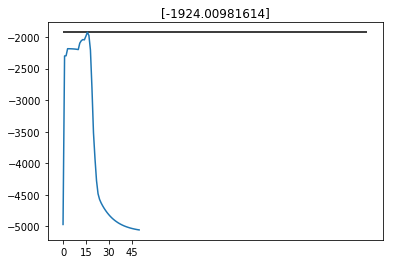

In [386]:
plt.plot(range(len(l)), l)
plt.hlines(best.log_likelihood(x01), 0, 200)
plt.title(best.log_likelihood(x01))

plt.xticks(np.arange(0, len(l), 15))

plt.show()

In [356]:
result = []
for idx, mix in enumerate(t.mixes):
    result.append(mix.pdf(x02) * t.pi[idx])
result = np.array(result)

In [382]:
t = best

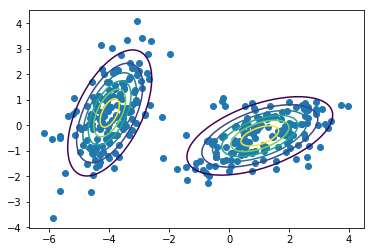

In [387]:
xmin, xmax = min(x01.T[0]), max(x01.T[0])
ymin, ymax = min(x01.T[1]), max(x01.T[1])

x, y = np.mgrid[xmin:xmax:.1, ymin:ymax:.1]
xy   = np.column_stack([x.ravel(), y.ravel()])

z = {}
for idx, mix in enumerate(t.mixes):
    z[idx] = mix.pdf(xy)
#z[0] = np.array(t.pdf(xy))
#z[0] = z[0].sum(axis=0)

plt.scatter(x01.T[0], x01.T[1])

for _ in z.values():
    plt.contour(x, y, np.reshape(_, x.shape))

plt.show()

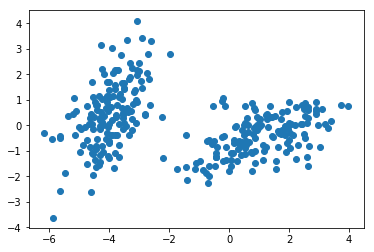

In [384]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(x01.T[0], x01.T[1])

ims = []

for i in range(20):
    t.iterate(x01)
    
    z = {}
    for idx, mix in enumerate(t.mixes):
        z[idx] = mix.pdf(xy)

    im = ax.contour(x, y, np.reshape(z[0], x.shape))
    add_arts1 = im.collections
    
    im = ax.contour(x, y, np.reshape(z[1], x.shape))
    add_arts2 = im.collections

    an = ax.annotate(i, xy=(0.45, 1.05), xycoords='axes fraction')
    
    ims.append(add_arts1 + add_arts2 + [an])

ani = ArtistAnimation(fig, ims)
ani.save('animation.gif', writer='imagemagick')

plt.show()